# Analyzing NYC High School Data

The purpose of this project is to analyze the relationship between SAT scores and various demographic factors in New York City. We will consider factors such as school safety, race, gender, and AP test scores. The data was originally obtained [here](https://data.cityofnewyork.us/browse?category=Education).

### Read in the data

In [1]:
import pandas as pd
import numpy as np
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

### Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

C:\Users\Cuyler\Anaconda3\envs\dqprojects\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


### Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

### Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

### Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

### Make a bar plot of correlations between survey fields and SAT scores

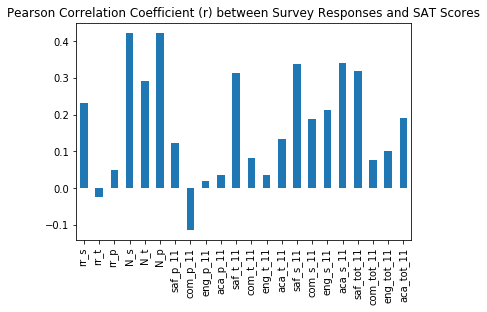

In [12]:
correlations[survey_fields].plot(kind='bar')
plt.title("Pearson Correlation Coefficient (r) between Survey Responses and SAT Scores")
plt.show()

The data dictionary for the survey fields plotted above can be found [here](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8). By consulting the data dictionary, we can determine that the fields with the strongest positive correlation with SAT scores are the number of survey responses from students and parents. While this may be indicative of student and parent investment in student success, it does not give us insight into a demographic factor which may influence SAT scores. The remaining fields which have the strongest positive correlations with SAT scores include:

- Safety and Respect scores based on teacher and student responses
- Academic expecations score based on student responses (but not teacher responses)

Let's investigate the correlation between SAT scores and Safety and Respect scores based on student responses.

### Exploring School Safety and SAT Scores

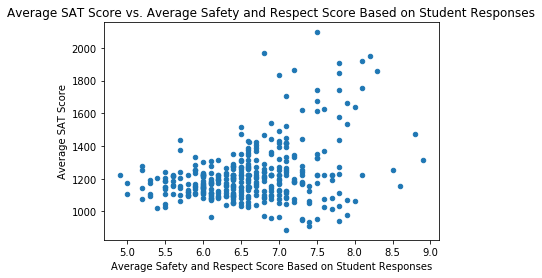

In [13]:
combined.plot(kind='scatter', x='saf_s_11', y='sat_score')
plt.title("Average SAT Score vs. Average Safety and Respect Score Based on Student Responses")
plt.xlabel("Average Safety and Respect Score Based on Student Responses")
plt.ylabel("Average SAT Score")
plt.show()

The scatter plot above confirms the positive correlation betwen SAT score and safety score based on student responses. This makes sense. If a student feels safe in their school environment, they will be able to focus on their academics. Let's now see if we can identify how the average safety score varies among school districts. We will compute the average safety score for each district and then map the districts to see if we can identify any patterns. For reference, here is a map of the five NYC boroughs to help identify which borough the school districts are located in:

![NYC Boroughs](nyc-borough-map.png)

In [14]:
districts_safety = combined.groupby('school_dist').agg(np.mean)
districts_safety.head()

,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
school_dist,,,,,,,,,,,,,,,,,,,,,
01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,115.244241,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,149.818949,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,156.005994,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,132.362265,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,120.623901,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251


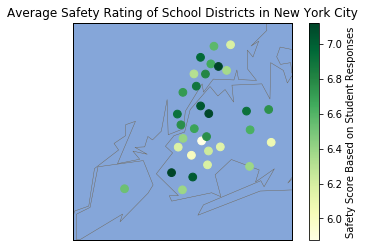

In [15]:
from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc',
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272, 
    resolution='i'
    )

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts_safety["lon"].tolist()
latitudes = districts_safety["lat"].tolist()

m.scatter(longitudes, latitudes, s=60, zorder=2, latlon=True, c=districts_safety['saf_s_11'], cmap='YlGn')
cbar = plt.colorbar()
cbar.set_label("Safety Score Based on Student Responses")
plt.title("Average Safety Rating of School Districts in New York City")
plt.show()

By comparing the above plot with the provided map of the New York City boroughs, it appears that most of the school districts with the lowest safety ratings are in central Brooklyn, while The Bronx and Queens each also have one low-ranking district. Manhattan appears to have the most consistently safe school districts in New York City.

### Exploring Race and SAT Scores

Let's now see what factor race plays in SAT scores in New York City. There are several columns in our dataframe which indicate the percentage of each race at a given school:

- `white_per`
- `asian_per`
- `black_per`
- `hispanic_per`

Let's see if we can find any correlations between these columns and SAT scores.

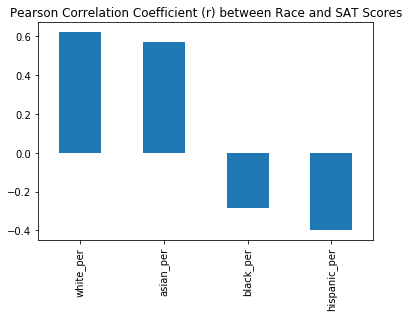

In [16]:
race_fields = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

correlations[race_fields].plot(kind='bar')
plt.title("Pearson Correlation Coefficient (r) between Race and SAT Scores")
plt.show()

It appears that the percentage of white and asian students in a school has a strong positive correlation with SAT scores. On the other hand, there is a negative correlation between the percentage of Black and Hispanic students in a school and SAT scores. Hispanic students have the strongest negative correlation with SAT scores. Thus, Hispanic students appear to be the most disadvantaged by the SAT test. Let's explore this correlation with a scatter plot.

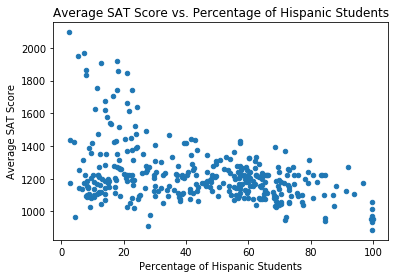

In [17]:
combined.plot(kind='scatter', x='hispanic_per', y='sat_score')
plt.title("Average SAT Score vs. Percentage of Hispanic Students")
plt.xlabel("Percentage of Hispanic Students")
plt.ylabel("Average SAT Score")
plt.show()

This scatter plot confirms the strong negative correlation betwen the percentage of Hispanic students in a school and SAT scores. Let's look specifically at the schools in New York City with > 95% Hispanic student population and see if we can find any patterns.

In [18]:
hispanic_per_greater_95 = combined.loc[combined['hispanic_per'] > 95]
print(hispanic_per_greater_95)

        DBN                                        SCHOOL NAME  \
44   02M542                      MANHATTAN BRIDGES HIGH SCHOOL   
82   06M348   WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL   
89   06M552  GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...   
125  09X365                ACADEMY FOR LANGUAGE AND TECHNOLOGY   
141  10X342              INTERNATIONAL SCHOOL FOR LIBERAL ARTS   
176  12X388   PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE   
253  19K583                          MULTICULTURAL HIGH SCHOOL   
286  24Q296             PAN AMERICAN INTERNATIONAL HIGH SCHOOL   

    Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
44                      66                            336.0   
82                      70                            380.0   
89                      56                            339.0   
125                     54                            315.0   
141                     49                            300.0   
176                     30 

By researching these 8 schools (insideschools.org), we can find some common themes:

- All of the schools have > 80% of students on free or reduced priced lunch. This is an indicator that most students at these schools come from low-income households.
- All but two of the schools have > 70% of students as English language learners.

It is clear that low-income students who are not native English speakers are disadvantaged by the SAT.

Now, let's look specifically at schools with lower than 10% Hispanic students and an average SAT score greater than 1800. We can then research these high-performing schools to see what differentiates them from the Hispanic schools in NYC.

In [19]:
hispanic_per_less_10_sat_1800 = combined.loc[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]
print(hispanic_per_less_10_sat_1800)

        DBN                                        SCHOOL NAME  \
37   02M475                             STUYVESANT HIGH SCHOOL   
151  10X445                       BRONX HIGH SCHOOL OF SCIENCE   
187  13K430                     BROOKLYN TECHNICAL HIGH SCHOOL   
327  28Q687  QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...   
356  31R605                STATEN ISLAND TECHNICAL HIGH SCHOOL   

    Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
37                     832                            679.0   
151                    731                            632.0   
187                   1277                            587.0   
327                    121                            612.0   
356                    227                            635.0   

     SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
37                 735.0                   682.0     2096.0   
151                688.0                   649.0     1969.0   
187                659.0           

By researching these 5 schools (insideschools.org), we can find some common themes:

- Each of these schools has Asian student populations of 50% or greater, with White students comprising the second-largest group.
- There are very few Black and Hispanic students at all five schools (less than 7% Hispanic, 6% Black)
- All 5 schools have fewer than 60% of students on free or reduced priced lunch
- The English language learner percentage for all 5 schools is 0%.

It is clear that the students at these elite high schools are native English speakers and are, in general, from higher-income families. Both of these factors are positive indicators for SAT scores.

### Exploring Gender and SAT Scores

There are two columns which indicate the percentage of each gender at a school:

- `male_per`
- `female_per`

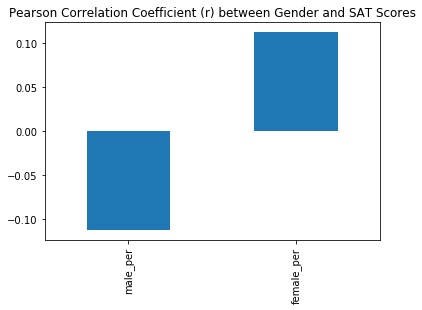

In [20]:
gender_fields = ['male_per', 'female_per']

correlations[gender_fields].plot(kind='bar')
plt.title("Pearson Correlation Coefficient (r) between Gender and SAT Scores")
plt.show()

While neither gender has a very strong correlation with gender one way or the other, it does appear that in general, female students perform better on the SAT than male students.

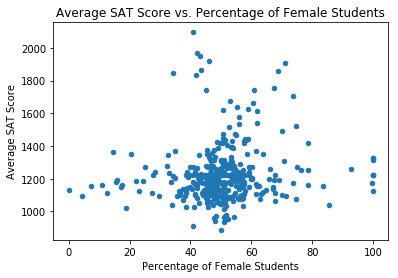

In [21]:
combined.plot(kind='scatter', x='female_per', y='sat_score')
plt.title("Average SAT Score vs. Percentage of Female Students")
plt.xlabel("Percentage of Female Students")
plt.ylabel("Average SAT Score")
plt.show()

Above we plotted the relationship between female student percentage and SAT scores. While there does not appear to be a strong postive or negative correlation, it does seem that schools that are greater than 80% male or female do not perform particularly well on the SAT.

There are a few high-performing schools in the 60-80% female range. Let's look at these schools more closely to see if we can identify any patterns.

In [22]:
female_per_greater_60_SAT_greater_1700 = combined.loc[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]
print(female_per_greater_60_SAT_greater_1700)

        DBN                                        SCHOOL NAME  \
5    01M696                     BARD HIGH SCHOOL EARLY COLLEGE   
26   02M416                      ELEANOR ROOSEVELT HIGH SCHOOL   
60   03M479                                 BEACON HIGH SCHOOL   
61   03M485  FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...   
302  25Q525                        TOWNSEND HARRIS HIGH SCHOOL   

    Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
5                      130                            624.0   
26                     127                            572.0   
60                     261                            577.0   
61                     531                            566.0   
302                    278                            621.0   

     SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
5                  604.0                   628.0     1856.0   
26                 594.0                   592.0     1758.0   
60                 575.0           

After researching these five schools on Google and Wikipedia, it appears that they are very selective college preparatory schools, and most are specialized in a certain area (such as performing arts, humanities, or liberal arts). It is not clear why these schools tend to have a majority-female student body.

### Exploring AP Test Scores and SAT Scores

Many high-performing high school students in the United States take Advanced Placement (AP) tests. It makes sense that students who take AP exams would correlated with high SAT scores. Let's explore this relationship and verify if this is reflected in our data.

In [26]:
combined['ap_per'] = combined['total_enrollment'] / combined['AP Test Takers ']

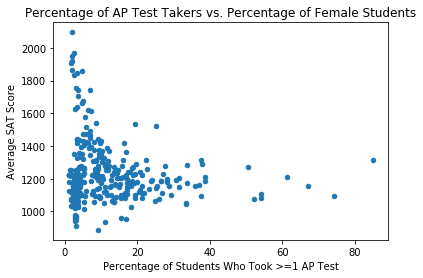

In [27]:
combined.plot(kind='scatter', x='ap_per', y='sat_score')
plt.title("Percentage of AP Test Takers vs. Percentage of Female Students")
plt.xlabel("Percentage of Students Who Took >=1 AP Test")
plt.ylabel("Average SAT Score")
plt.show()

Surprisingly, the percentage of students who took at least 1 AP test is not strongly correlated with average SAT score. In fact, all of the schools with the highest SAT scores had very low percentages of students take an AP test. This relationship would be worth investigating further.